<a href="https://colab.research.google.com/github/huggingface/data-is-better-together/blob/main/prompt_translation/setup_prompt_translation_space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color: #f44336; padding: 20px; color: white; font-size: 24px; font-weight: bold; border-radius: 10px;">
<h1> ⚠️ WARNING! ⚠️<br></h1>
It is very important that you ensure that you don't carry out any annotations using the Argilla Space until you receive a confirmation message on Discord that persistent storage is enabled. If you carry out annotations before this, your work will be deleted or lost when we do the upgrade. We will not be able to restore any data lost in this way.
</div>

# 2. Uploading prompts to be translated to an Argilla Space 

This notebook focuses on the steps involved in uploading prompts to be translated to an Argilla Space. It assumes you have already created an Argilla Space and have the Space ID and API key. If you haven't created an Argilla Space yet, please refer to the previous notebooks and the overall README for instructions on how to do so.

## Steps

This notebook picks up from the previous notebook in which you setup an Argilla Space with Oauth authentication and requested an upgrade to persistent storage. In this notebook we'll finish the setup instructions by covering the following steps. 

1. Loading the DIBT data into the Argilla Space
2. (Optional) machine translating the prompts to the target language as a starting point

Install the required libraries by running the cell below.

In [1]:
%pip install huggingface_hub argilla datasets openai -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.

## Load the DIBT data into the Argilla Space


First we need to set up the Argilla SDK client with the URL and owner credentials for our space

<div class="alert alert-warning">
  <strong>Warning!</strong> Make sure you have persistent storage enabled before you proceed to the next steps, if you haven't done this there is a strong danger of losing data. Please reach out on Discord to make sure this step has been done!
</div>

In [22]:
import json

In [16]:
SPACE_ID =  "DIBT-for-Esperanto/prompt-translation-for-Esperanto"
HOMEPAGE_URL = "https://dibt-for-esperanto-prompt-translation-for-esperanto.hf.space"
LANGUAGE = None, # i.e. "French"

In [27]:
assert SPACE_ID and HOMEPAGE_URL and LANGUAGE, "Please set SPACE_ID and HOMEPAGE_URL to your space ID and homepage URL"

In [18]:
from huggingface_hub import space_info


assert space_info(SPACE_ID).runtime.storage.get("current") == "small", "Please ensure you have setup persistent storage for your space. Please see steps above"

In [19]:
import argilla as rg

OWNER_API_KEY = "owner.apikey" # if you haven't setup the secret this is the default owner api key
assert OWNER_API_KEY is not None, "Please set OWNER_API_KEY to the API token you just set in the Space settings"

rg.init(api_url=HOMEPAGE_URL, api_key=OWNER_API_KEY)

/Users/davanstrien/Documents/code/argilla/data-is-better-together/kto-preference/.venv/lib/python3.11/site-packages/argilla/client/client.py:178: UserWarning: No workspace configuration was detected. To work with Argilla datasets, specify a valid workspace name on `rg.init` or set it up through the `rg.set_workspace` function.
  warnings.warn(


Finally, we're ready to create our dataset in the `admin` workspace. To test that everything is working let's upload the original dataset (without translation), you can later delete this dataset from the UI or via the SDK.

In [20]:
from datasets import load_dataset

# load the dataset from the Hub
ds = load_dataset('DIBT/prompts_ranked_multilingual_benchmark')

Generating train split:   0%|          | 0/501 [00:00<?, ? examples/s]

In [21]:
# create the dataset with a pre-built template
argilla_ds = rg.FeedbackDataset.for_translation(
    use_markdown=True,
    guidelines=None,
    metadata_properties=None,
    vectors_settings=None,
)
argilla_ds

FeedbackDataset(
   fields=[TextField(name='source', title='Source', required=True, type='text', use_markdown=True)]
   questions=[TextQuestion(name='target', title='Target', description='Translate the text.', required=True, type='text', use_markdown=True)]
   guidelines=This is a translation dataset that contains texts. Please translate the text in the text field.)
   metadata_properties=[])
   vectors_settings=[])
)

In [23]:
# create records
records = []
for row in ds["train"]:
    record = rg.FeedbackRecord(
        fields={"source": row["prompt"]},
        metadata=json.loads(row["metadata"]),
        external_id=row["row_idx"],
    )
    records.append(record)

In [24]:
# add records to the dataset
argilla_ds.add_records(records)

In [26]:
# push the dataset to Argilla
argilla_ds.push_to_argilla(f"DIBT Translation for {LANGUAGE}", workspace="admin")

Output()

[03/22/24 15:54:20] INFO     INFO:argilla.client.feedback.dataset.local.mixins:✓ Dataset succesfully  ]8;id=325071;file:///Users/davanstrien/Documents/code/argilla/data-is-better-together/kto-preference/.venv/lib/python3.11/site-packages/argilla/client/feedback/dataset/local/mixins.py\mixins.py]8;;\:]8;id=591836;file:///Users/davanstrien/Documents/code/argilla/data-is-better-together/kto-preference/.venv/lib/python3.11/site-packages/argilla/client/feedback/dataset/local/mixins.py#281\281]8;;\
                             pushed to Argilla                                                                     

                    INFO     INFO:argilla.client.feedback.dataset.local.mixins:RemoteFeedbackDataset( ]8;id=808431;file:///Users/davanstrien/Documents/code/argilla/data-is-better-together/kto-preference/.venv/lib/python3.11/site-packages/argilla/client/feedback/dataset/local/mixins.py\mixins.py]8;;\:]8;id=685396;file:///Users/davanstrien/Documents/code/argilla/data-is-better-together/kto-preference/.venv/lib/python3.11/site-packages/argilla/client/feedback/dataset/local/mixins.py#282\282]8;;\
                                id=5969f31a-f234-42f9-8ed3-f0e7ff0fc13f                                            
                                name=DIBT Translation for French                                                   
                                workspace=Workspace(id=bae8ab3c-ae62-409c-8744-7d9feb2db3b2,                       
                             name=admin, inserted_at=2024-03-12 21:04:16.149557,                                   
                             updated_at=2024-03-12 21:04:16.149557)                                                
                                url=https://dibt-for-esperanto-prompt-translation-for-esperanto.hf.sp              
                             ace/dataset/5969f31a-f234-42f9-8ed3-f0e7ff0fc13f/annotation-mode                      
                                fields=[RemoteTextField(id=UUID('6ee02855-6e56-4cfd-9e77-f664390abfd4              
                             '), client=None, name='source', title='Source', required=True,                        
                             type='text', use_markdown=True)]                                                      
                                questions=[RemoteTextQuestion(id=UUID('41016c56-2b21-4135-b6cf-7fe8ad              
                             10dac4'), client=None, name='target', title='Target', description=None,               
                             required=True, type='text', use_markdown=True)]                                       
                                guidelines=This is a translation dataset that contains texts. Please               
                             translate the text in the text field.                                                 
                                metadata_properties=[]                                                             
                                vectors_settings=[]                                                                
                             )                                                                                     

RemoteFeedbackDataset(
   id=5969f31a-f234-42f9-8ed3-f0e7ff0fc13f
   name=DIBT Translation for French
   workspace=Workspace(id=bae8ab3c-ae62-409c-8744-7d9feb2db3b2, name=admin, inserted_at=2024-03-12 21:04:16.149557, updated_at=2024-03-12 21:04:16.149557)
   url=https://dibt-for-esperanto-prompt-translation-for-esperanto.hf.space/dataset/5969f31a-f234-42f9-8ed3-f0e7ff0fc13f/annotation-mode
   fields=[RemoteTextField(id=UUID('6ee02855-6e56-4cfd-9e77-f664390abfd4'), client=None, name='source', title='Source', required=True, type='text', use_markdown=True)]
   questions=[RemoteTextQuestion(id=UUID('41016c56-2b21-4135-b6cf-7fe8ad10dac4'), client=None, name='target', title='Target', description=None, required=True, type='text', use_markdown=True)]
   guidelines=This is a translation dataset that contains texts. Please translate the text in the text field.
   metadata_properties=[]
   vectors_settings=[]
)

At this point, the dataset is available in the UI. To be able to delete you need to log in with the user `owner` and the password you have setup in the secrets or the default one which is `12345678` if you haven't added the secret.

## Translate the source dataset and push it to Argilla

The only remaining step is to translate the dataset and create the final dataset your contributors will be annotating.

There are different options to translate the dataset, such as:

- Using Open Source models, like: nllb-200, Google-T5, OPUS-MT
- Using Closed LLM API providers like OpenAI with gpt-4-turbo or Mistral with mistral-large

### Translation models

#### Open Source models

We will first start with an example of a translation pipeline with open source models. Even though these models are able to run on CPU it is highly recommended to use a GPU in order to speed up inference.

We will use the [No Language Left Behind (NLLB) intiative from Meta](https://ai.meta.com/blog/nllb-200-high-quality-machine-translation/). A distilled version of this [model is available on Hugging Face](https://huggingface.co/facebook/nllb-200-distilled-600M). This model workd accross 200 different language and their language codes can be found in [this readme](https://huggingface.co/facebook/nllb-200-distilled-600M/blob/main/README.md).

First, we will initialize the model with a correct `src_lang`.

In [31]:
# !pip install 'transformers[torch]'

In [32]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

model_path = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_path, src_lang="eng_Latn")
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Check if a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move the model and tokenizer to the GPU if available
model = model.to(device)

Next, we will define a translation function that takes a `text: Union[str, List[str]]` and a correct `trg_lang`.

In [33]:
def open_translate(texts, trg_lang):
    if isinstance(texts, str):  # If a single text is provided, convert it to a list
        texts = [texts]

    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    translated_tokens = model.generate(
        **inputs.to(device), forced_bos_token_id=tokenizer.lang_code_to_id[trg_lang]
    )
    translations = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)

    if len(translations) == 1:
        return translations[0]
    else:
        return translations


example = "We will first start with an example of a translation pipeline with open source models. Even though these models are able to run on CPU it is highly recommended to use a GPU in order to speed up inference."
open_translate(example, "spa_Latn")

the `lang_code_to_id` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38


'Comenzaremos con un ejemplo de una tubería de traducción con modelos de código abierto.'

#### Other models and closed source LLM API providers

Depending on the language you are working in the NLLB model used above might not work so well. One alternative is to use a specific translation model for your language. You can find many of these on the Hugging Face Hub with examples showing how to use them. Alternatively, you might use a closed LLM provider. We provide a separate example of using one of these notebooks [here](https://github.com/huggingface/data-is-better-together/blob/main/prompt_translation/Translation_with_distilabel_gpt_4_turbo.ipynb). If you want to use this alternative approach you may want to jump straight to that notebook and skip the rest of this notebook!

### Add translations as suggestions

Now, we will use the defined translation functions to add some pre-filled translation suggestions to the Argilla dataset.

In [ ]:
argilla_ds = rg.FeedbackDataset.from_argilla(f"DIBT Translation for {LANGUAGE}", workspace="admin")
argilla_ds

Next, we will loop through the records and add a translation.

In [ ]:
from tqdm.auto import tqdm

In [ ]:
altered_records = []
for rec in tqdm(argilla_ds.records):
    rec.suggestions = [
        {
            "question_name": "target",
            "value": open_translate(rec.fields["source"], "spa_Latn")
        }
    ]
    altered_records.append(rec)

Lastly, we will update these records within Argilla.

In [ ]:
# Example of doing this with a closed model
# altered_records = []
# for rec in tqdm(argilla_ds.records):
#     rec.suggestions = [
#         {
#             "question_name": "target",
#             "value": closed_translate(
#                 rec.fields["source"],
#                 "spa_Latn",
#                 max_tokens=len(rec.fields["source"]) + 10,
#             ),
#         }
#     ]
#     altered_records.append(rec)

In [ ]:
argilla_ds.update_records(altered_records)

## 9. Create a dashboard to track the annotation efforts

Once you have your annotation suite running on a Hugging Face Space, you can easily set up an dashboard for tracking the annotation effort. Check out how the Spanish one looks like!

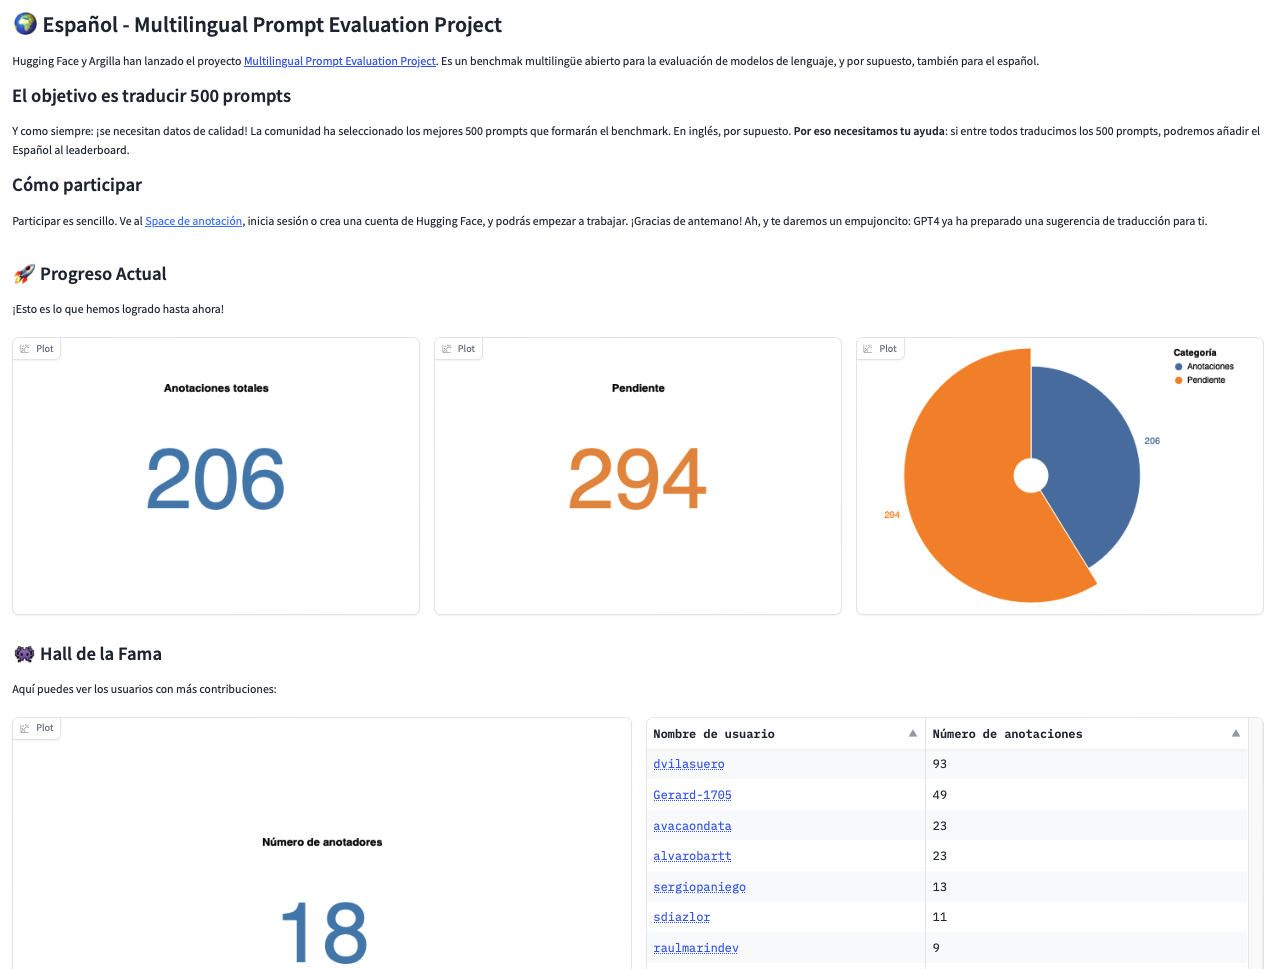

There are some variables that you need to gather first, as they are used to obtain the data from the annotation space. They are:

- `SOURCE_DATASET`: The string name of your dataset, for example the Spanish team uses `DIBT Translation for es`. 
- `SOURCE_WORKSPACE`: The workspace id of the source dataset (unless otherwise specified, this will be `admin`)
- `TARGET_RECORDS`: The number of records that you have as a target to annotate. We usually set this to 500.
- `ARGILLA_API_URL`: Link to the Huggingface Space where the annotation effort is being hosted. For example, the Spanish one is https://somosnlp-dibt-prompt-translation-for-es.hf.space/
- `ARGILLA_API_KEY`: The API key to access the Huggingface Space. Please, write this as a secret in the Huggingface Space configuration. You can access this key by logging in to your Ariglla Space, clicking your user avatar in the upper-right corner, selected _My Settings_ and navigating to the API Key parameter. Click **Copy Key** to copy the required data.

Once this is done, you can find an example of a dashboard application in the folder `dashboard_template`. With a few tweaks, it'll be up and running.

First, within your organization, please create a new Hugging Face Space with Gradio. The free configuration is enough. Then, set the previous variables as environment variables within the Space configuration, with `ARGILLA_API_KEY` as a secret. 

Then, you have to upload and push the dashboard template. There are several ways to do it, but we recommend either uploading it directly through the Hugging Face Space website, or cloning the repository and pushing it from your favorite code editor. Note that the template needs to be translated to the language of your choice, both the constants at the beginning of `app.py` and the Markdown content at the end of the same file. Push it, and the dashboard should be ready!

Do not hesitate to share with us the API URL and API KEY of your annotation suite and your dashboard, and we will include the details of your annotation effort in our global tracker and our GitHub page.